# Machine Learning

First of all, let's import all the modules that we will use. 

In [1]:
##Imports needed plugins

import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt 
import plotly.express as px
import plotly.graph_objects as go
import warnings
import seaborn as sns
import pydotplus

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import recall_score
from sklearn.externals.six import StringIO  
from IPython.display import Image 
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

#!pip install pydotplus
#!pip install graphviz

sns.set_style("darkgrid")
warnings.filterwarnings("ignore")

//anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



We import now the dataset and display it.

In [67]:
# Import the data
data = pd.read_csv("../data/DataWithLocationCleaned.csv.gz")
# correct Date types 
data['Date'] = pd.to_datetime(data['Date'])
df = data.copy()
df.head()



,Port Name,State,Port Code,Border,Date,Measure,Value,Year,Month,position
0,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Truck Containers Full,133,2019,6,"(48.905266, -95.314404)"
1,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Truck Containers Empty,298,2019,6,"(48.905266, -95.314404)"
2,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Personal Vehicles,10383,2019,6,"(48.905266, -95.314404)"
3,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Personal Vehicle Passengers,19459,2019,6,"(48.905266, -95.314404)"
4,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Pedestrians,2,2019,6,"(48.905266, -95.314404)"


We create 2 separate dataframes, one for the people's counting measures and one for the traffic's counting measures.

In [4]:
# Add lagitude and longitude
# Create one dataFrame for persons and one only for traffic
def getlat(x):
    lat = x.partition(',')[0][1:]
    if lat[0] == "'":
        lat = lat[1:-1]
    return lat

def getlong(x):
    lat = x.partition(',')[2]
    if lat[1] == "'":
        lat = lat[2:-2]
    else:
        lat = lat[1:-1]
    return lat

df['latitude'] = df['position'].apply(lambda x: getlat(x))
df['longitude'] = df['position'].apply(lambda x: getlong(x))
persons = df[df['Measure'].isin(['Bus Passengers','Pedestrians','Personal Vehicle Passengers','Train Passengers'])].reset_index().drop(columns=['index'])
nozero = persons[persons['Value'] != 0]
ports = df['Port Name'].unique()
nozero.head()

,Port Name,State,Port Code,Border,Date,Measure,Value,Year,Month,position,latitude,longitude
0,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Personal Vehicle Passengers,19459,2019,6,"(48.905266, -95.314404)",48.905266,-95.314404
1,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Pedestrians,2,2019,6,"(48.905266, -95.314404)",48.905266,-95.314404
2,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Bus Passengers,63,2019,6,"(48.905266, -95.314404)",48.905266,-95.314404
3,Roseau,Minnesota,3426,US-Canada Border,2019-06-01,Personal Vehicle Passengers,7385,2019,6,"(48.7710371, -95.7697882)",48.7710371,-95.7697882
4,Roseau,Minnesota,3426,US-Canada Border,2019-06-01,Bus Passengers,118,2019,6,"(48.7710371, -95.7697882)",48.7710371,-95.7697882


We create a list of unique ports.

In [5]:
# Create a list of ports
ports = nozero['Port Name'].unique()
ports

array(['Warroad', 'Roseau', 'Detroit', 'Del Rio', 'Anacortes', 'Sumas',
       'Port Angeles', 'Point Roberts', 'Oroville', 'Nighthawk',
       'Metaline Falls', 'Lynden', 'Laurier', 'Frontier', 'Friday Harbor',
       'Ferry', 'Danville', 'Boundary', 'Blaine', 'Richford', 'Norton',
       'Highgate Springs-Alburg', 'Derby Line', 'Beecher Falls',
       'Tornillo-Fabens', 'Roma', 'Rio Grande City', 'Progreso',
       'Presidio', 'Laredo', 'Hidalgo', 'El Paso', 'Eagle Pass',
       'Brownsville', 'Boquillas', 'Trout River', 'Ogdensburg', 'Massena',
       'Champlain-Rouses Point', 'Cape Vincent', 'Buffalo-Niagara Falls',
       'Alexandria Bay', 'Santa Teresa', 'Columbus', 'Westhope',
       'Walhalla', 'St. John', 'Sherwood', 'Sarles', 'Portal', 'Pembina',
       'Pinecreek', 'Lancaster', 'International Falls-Ranier',
       'Grand Portage', 'Dalton Cache', 'Ketchikan', 'Skagway', 'Douglas',
       'Lukeville', 'Naco', 'Nogales', 'San Luis', 'Sasabe', 'Andrade',
       'Calexico', 'Cal

Now that we have the data ready, we will work on different regression techniques.


# Logistic regression

Let's first define some functions in order to use them later on.


In [7]:
def logistic(X,y,baseRate):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    LR = LogisticRegressionCV(solver='lbfgs', cv=5, max_iter=1000)
    LR.fit(X_train,y_train)
    test_score = LR.score(X_test, y_test)
    train_score = LR.score(X_train,y_train)
    print("train_score :",train_score,"test_score =",test_score)
    return [train_score,test_score,confusion_matrix(y_train, LR.predict(X_train)),baseRate]

def encodeOneHot(z,f,i):
    test = z
    baseRate = pd.qcut(test['Value'],q = i, duplicates = 'drop').value_counts()
    print("Base rate :",baseRate.max()/baseRate.sum())
    print()
    test['quant'] = pd.qcut(test['Value'],q = i, duplicates = 'drop')
    print(i, " intervals for y:")
    print(test['quant'].value_counts())
    print()
    le = LabelEncoder()
    y = le.fit_transform(test["quant"])
    y.shape
    one_hot = OneHotEncoder(categories="auto")
    categoricals = []
    features = f.copy()
    for feature in f:
        if feature in ['Measure','State','Border']:
            categoricals.append(feature)
            features.remove(feature)
              
    cat_to_onehot = one_hot.fit_transform(test[categoricals]).toarray()
    cat_to_onehot = pd.DataFrame(cat_to_onehot)
    X = pd.concat((test[features].reset_index(drop=True),cat_to_onehot.reset_index(drop=True)),axis=1)
    return logistic(X,y,baseRate.max()/baseRate.sum())

def  computeLogistic(dataset,ports,f,i):
    if (len(f) == 0):
        return
    Zone = dataset[dataset['Port Name'].isin(ports)].reset_index(drop=True)
    return encodeOneHot(Zone,f,i)


### Find a good number of intervals

We test which number of intervals is the best to use in order to compute logistic regression. We try numbers between 2 and 9, because of the lack of computing power on our machine and the time required to finish the execution.


In [8]:
test = []
for i in range(2,10):
    test.append([i,computeLogistic(nozero,ports,['Measure','Port Code','State','latitude','longitude'],i)])

Base rate : 0.5000396699460489

2  intervals for y:
(0.999, 2394.0]        37815
(2394.0, 4447374.0]    37809
Name: quant, dtype: int64

train_score : 0.8219144118084596 test_score = 0.8216859504132231
Base rate : 0.3335977996403258

3  intervals for y:
(0.999, 501.0]            25228
(11238.333, 4447374.0]    25208
(501.0, 11238.333]        25188
Name: quant, dtype: int64

train_score : 0.6876807881122002 test_score = 0.691107438016529
Base rate : 0.2500925632074474

4  intervals for y:
(0.999, 190.0]          18913
(32053.0, 4447374.0]    18906
(2394.0, 32053.0]       18903
(190.0, 2394.0]         18902
Name: quant, dtype: int64

train_score : 0.5725053306666226 test_score = 0.5818181818181818
Base rate : 0.20034645086216016

5  intervals for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.5242731284814625 test_score = 0.5268099173553719


In [16]:
intervalls_testError = []
for i in range(0,len(test)):
    intervalls_testError.append([test[i][0],test[i][1][0],test[i][1][1],test[i][1][3]])
print(intervalls_testError)

[[2, 0.8219144118084596, 0.8216859504132231, 0.5000396699460489], [3, 0.6876807881122002, 0.691107438016529, 0.3335977996403258], [4, 0.5725053306666226, 0.5818181818181818, 0.2500925632074474], [5, 0.5242731284814625, 0.5268099173553719, 0.20034645086216016], [6, 0.46094976776475644, 0.46261157024793387, 0.16703691949645616], [7, 0.405130663316749, 0.40826446280991735, 0.14404157410345922], [8, 0.38083274103704196, 0.38783471074380166, 0.12650745794985718], [9, 0.3437412188631217, 0.343603305785124, 0.11221305405691315]]


In [17]:
intervalls_testError = pd.DataFrame(intervalls_testError)
intervalls_testError = intervalls_testError.rename(columns={0:"intervalls",1: "train_error",2:"testerror",3:"baserate"})
intervalls_testError['diff'] = intervalls_testError['testerror']-intervalls_testError['baserate']
intervalls_testError

,intervalls,train_error,testerror,baserate,diff
0,2,0.821914,0.821686,0.500040,0.321646
1,3,0.687681,0.691107,0.333598,0.357510
2,4,0.572505,0.581818,0.250093,0.331726
3,5,0.524273,0.526810,0.200346,0.326463
4,6,0.460950,0.462612,0.167037,0.295575
5,7,0.405131,0.408264,0.144042,0.264223
6,8,0.380833,0.387835,0.126507,0.261327
7,9,0.343741,0.343603,0.112213,0.231390


We plot now our results on a graph to better visualise them.

Just a qick little reminder:

- Base rate:

   - calculation: size of the biggest interval/ total number of observations

   - the goal of the base rate is to be slightly better than a random guess 
if intervals are balanced

- Train error:

    - precision of our model on the train sample

- Test error:

    - precision of our model on the test sample


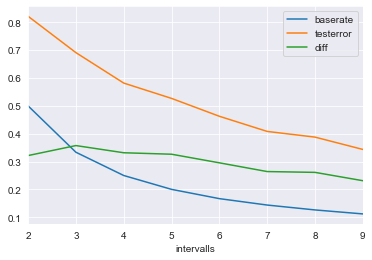

In [18]:
intervalls_testError.plot(x="intervalls", y=["baserate","testerror","diff"])

We can see that having 5 intervals is a good compromise. The performance is acceptable and the number of observations in each interval sufficient.

The main goal was here to observe the difference between the base rate and the test error. Ideally, we should have taken an interval bigger than 5 where the test error was at the lowest point, but the running time would have been to long. 


### Find the best combination of parameters

Now that we know that using 5 intervals gives us the best results, we have to find which combination of parameters gives us the best prediction.


In [19]:
L1 = computeLogistic(nozero,ports,['Measure'],5)

Base rate : 0.20034645086216016

5  intervals for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.36977470701995074 test_score = 0.3703801652892562


In [20]:
L2 = computeLogistic(nozero,ports,['Port Code'],5)

Base rate : 0.20034645086216016

5  intervals for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.245888361791104 test_score = 0.23735537190082645


In [21]:
L3 = computeLogistic(nozero,ports,['Measure','Port Code'],5)

Base rate : 0.20034645086216016

5  intervals for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.44347840460172894 test_score = 0.4432396694214876


In [22]:
L4 = computeLogistic(nozero,ports,['Measure','Port Code','Month'],5)

Base rate : 0.20034645086216016

5  intervals for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.44362716739119656 test_score = 0.44502479338842976


In [23]:
L5 = computeLogistic(nozero,ports,['Measure','Port Code','Year'],5)


Base rate : 0.20034645086216016

5  intervals for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.45207358799319 test_score = 0.45269421487603306


In [24]:
L6 = computeLogistic(nozero,ports,['Measure','Port Code','Year','Month'],5)

Base rate : 0.20034645086216016

5  intervals for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.4442387477478967 test_score = 0.44469421487603306


In [25]:
L7 = computeLogistic(nozero,ports,['Measure','Port Code','State'],5)

Base rate : 0.20034645086216016

5  intervals for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.5192151936395643 test_score = 0.5215206611570248


In [26]:
L8 = computeLogistic(nozero,ports,['Measure','Port Code','State','latitude'],5)

Base rate : 0.20034645086216016

5  intervals for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.5241574240896544 test_score = 0.5265454545454545


In [27]:
L9 = computeLogistic(nozero,ports,['Measure','Port Code','State','latitude','longitude'],5)

Base rate : 0.20034645086216016

5  intervals for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.5242731284814625 test_score = 0.5268099173553719


In [28]:
L10 = computeLogistic(nozero,ports,['Measure','Port Code','State','latitude','longitude','Border'],5)

Base rate : 0.20034645086216016

5  intervals for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.5279591398204929 test_score = 0.5302479338842975


In [29]:
L11 = computeLogistic(nozero,ports,['Measure','Port Code','State','Year','latitude','longitude'],5)

Base rate : 0.20034645086216016

5  intervals for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.5219425114464702 test_score = 0.5254214876033058


In [30]:
L12 = computeLogistic(nozero.sort_values(by=['Date']).reset_index(drop=True),ports,['Measure','Port Code','State','latitude','longitude','Border'],5)

Base rate : 0.20034645086216016

5  intervals for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.5171986313823369 test_score = 0.5261487603305786


 The best combination (L10) of parameters is 'Measure', 'Port Code', 'State', 'latitude', 'longitude', 'Border' and has a test score of 0.53. So, these parameters explain our model's predictions the best.

Sorting the values by date helps to improve our model only by 1%. The date has probably an impact only on a few periods related to some external events. So, the general trend is relatively not impacted by those few events.

We can now plot the confusion matrix for L10:


In [31]:
#Plot the confusion matrix for l10
L10[2]

array([[ 8946,  2749,   107,   136,   127],
       [ 4087,  5353,  1655,   578,   422],
       [ 2825,  1757,  4348,  1186,  2036],
       [  894,   821,  3621,  2723,  4062],
       [   39,   125,   451,   880, 10571]])

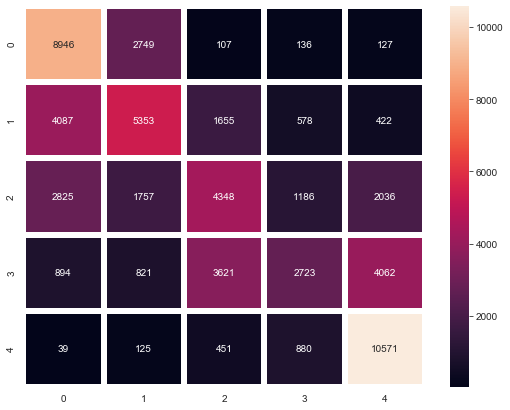

In [32]:
plt.subplots(figsize=(9,7))
sns.heatmap(L10[2], annot=True,fmt='g',linewidths=5)

### Logistic regression on ports

Let's now perform a logistic regression on a single port at a time. In order to make sure that we have enough data for the regression, we will only keep the ports that have more than 800 values not equal to 0.


In [33]:
#We create a list of "good" ports : these ports will have more than 800 values not equal to 0.
error_port= []
for port in ports:
    if (nozero[(nozero['Port Name'] == port)].shape[0]>800):
        error_port.append([port,computeLogistic(nozero,[port],['Measure','Port Code','State','latitude','longitude','Border'],5)])

Base rate : 0.20039486673247778

5  intervals for y:
(14014.0, 49762.0]    203
(500.8, 1297.6]       203
(0.999, 88.4]         203
(1297.6, 14014.0]     202
(88.4, 500.8]         202
Name: quant, dtype: int64

train_score : 0.6493827160493827 test_score = 0.6896551724137931
Base rate : 0.2

5  intervals for y:
(650030.8, 2473401.0]    173
(74705.0, 650030.8]      173
(16619.6, 74705.0]       173
(917.4, 16619.6]         173
(359.999, 917.4]         173
Name: quant, dtype: int64

train_score : 0.6213872832369942 test_score = 0.6242774566473989
Base rate : 0.2

5  intervals for y:
(110083.2, 307761.0]    224
(4109.4, 110083.2]      224
(2459.4, 4109.4]        224
(305.4, 2459.4]         224
(2.999, 305.4]          224
Name: quant, dtype: int64

train_score : 0.6004464285714286 test_score = 0.5848214285714286
Base rate : 0.200734394124847

5  intervals for y:
(118028.4, 1507021.0]    164
(1465.6, 2250.0]         164
(3.999, 939.2]           164
(939.2, 1465.6]          163
(2250.0, 118028

In [34]:
port_localisation = []
for i in range(0,len(error_port)):
    port_localisation.append([error_port[i][0],error_port[i][1][0],error_port[i][1][1]])

We can now plot the test score of each "good" port on the map of the USA.

In [36]:
port_localisation =  pd.DataFrame(data = port_localisation,columns = ['Port Name','Train Score','Test Score'])
ps = nozero[['Port Name','latitude']].drop_duplicates().set_index('Port Name')
port_localisation['latitude'] = port_localisation['Port Name'].apply(lambda x : ', '.join(ps.loc[x].values.flatten()))
ps = nozero[['Port Name','longitude']].drop_duplicates().set_index('Port Name')
port_localisation['longitude'] = port_localisation['Port Name'].apply(lambda x : ', '.join(ps.loc[x].values.flatten()))
port_localisation['text'] = port_localisation['Port Name'] + '<br>Test Score: ' + (port_localisation['Test Score']).astype(str)



fig = go.Figure(data=go.Scattergeo(
        locationmode = 'USA-states',
        lon = port_localisation['longitude'],
        lat = port_localisation['latitude'],
        text = port_localisation['text'],
        mode = 'markers',
        marker = dict(
            size = 10,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'Reds',
            cmin = 0,
            color = port_localisation['Test Score'],
            cmax = port_localisation['Test Score'].max(),
            colorbar_title="Test_score"
        )))

fig.update_layout(
        title = 'Test score per port ',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )
fig.show()

The ports that are represented with white boxes have the highest test scores. So, our model is really performant for predicting the value intervals on these ports. 

# Linear Regression

In the logistic regression, we've tried to predict categories of intervals. With the linear regression, we will try to predict the exact value.

So, here, we create a linear regression with the logValue of y. 

In [37]:
y = np.log(nozero['Value'])

In [38]:
y.head()

0    9.876065
1    0.693147
2    4.143135
3    8.907206
4    4.770685
Name: Value, dtype: float64

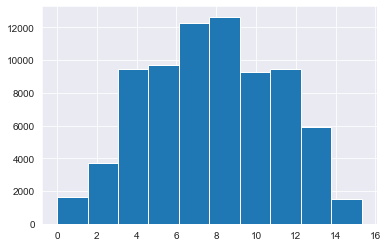

In [39]:
y.hist()

In [64]:
def linear(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    iowa_model = LinearRegression()
    iowa_model.fit(X_train,y_train)
    test_score = iowa_model.score(X_test, y_test)
    train_score = iowa_model.score(X_train,y_train)
    #print("train_score :",train_score,"test_score =",test_score)
    return test_score
    
def linearRegression(f):
    one_hot = OneHotEncoder(categories="auto")
    categoricals = []
    features = f.copy()
    for feature in f:
        if feature in ['Measure','State','Border']:
            categoricals.append(feature)
            features.remove(feature)
    cat_to_onehot = one_hot.fit_transform(nozero[categoricals]).toarray()
    cat_to_onehot = pd.DataFrame(cat_to_onehot)
    X = pd.concat((nozero[features].reset_index(drop=True),cat_to_onehot.reset_index(drop=True)),axis=1)
    
    return linear(X,y)

We want now to see which combination of features shows the best results. 

In [65]:
f = ['Measure','Port Code','State','latitude','longitude','Border','Year','Month']
def computelinReg(f):
    listcomb = []
    Regrtestsore = {}
    for i in range(len(f)+1):
        for combination in itertools.combinations(f, i): 
            listcomb.append(combination)
    
    listcomb.pop(0)
    for i in range(len(listcomb)):
        Regrtestsore.update({listcomb[i]: linearRegression(list(listcomb[i]))})
        #print(listcomb[i])
    
    key_max = max(Regrtestsore, key=Regrtestsore.get)
    print(key_max, Regrtestsore[key_max])
    
    return key_max
                            
        

In [66]:
computelinReg(f)

('Measure', 'Port Code', 'State', 'latitude', 'longitude', 'Border', 'Year') 0.6240081257053474


('Measure', 'Port Code', 'State', 'latitude', 'longitude', 'Border', 'Year')

We can see that the best predicting features are slightly different than in the logistic regression.

BEFORE: 

The best combination of parameters was 'Measure', 'Port Code', 'State', 'latitude', 'longitude', 'Border' for a test score of 0.53. 

NOW:

The best combination of parameters is 'Measure', 'Port Code', 'State', 'latitude', 'longitude', 'Border', 'Year' for a test score of 0.624.

If we print all possible combinations, we can see that the previous best combination in logistic regression has here in linear regression a test score of 0.622.


Because the logistic regression is more performant at predicting categorical dependant variables like yes or no, here, our linear regression shows better results in comparison with our logistic regression.

# Decision Tree

We will now try to do a decision tree in order to compare it later with a random forest. 

A little quick reminder on why we use the nozero dataframe:

- Total number of observations in the persons dataframe: 116131

- Total number of observations in the persons dataframe whithout the ports containing less than 1100 values: 10147 et 9 ports

- Total number of observations in the persons dataframe whithout half of the observations in the first interval: 86870 

- Total number of observations in the nozero dataframe: 75624

So, to find a good compromise between the number of observations and the interpretation possibilities, we decided to focus on the nozero database.


In [223]:
nozero['quant'] = pd.qcut(nozero['Value'],q = 5, duplicates = 'drop')
print("intervalls for y:")
print(nozero['quant'].value_counts())
print()
le = LabelEncoder()
nozero['y'] = le.fit_transform(nozero["quant"])

intervalls for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64



In [224]:
nozero.reset_index().head()

,index,Port Name,State,Port Code,Border,Date,Measure,Value,Year,Month,position,latitude,longitude,quant,y
0,0,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Personal Vehicle Passengers,19459,2019,6,"(48.905266, -95.314404)",48.905266,-95.314404,"(6087.8, 57873.4]",3
1,1,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Pedestrians,2,2019,6,"(48.905266, -95.314404)",48.905266,-95.314404,"(0.999, 103.0]",0
2,2,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Bus Passengers,63,2019,6,"(48.905266, -95.314404)",48.905266,-95.314404,"(0.999, 103.0]",0
3,3,Roseau,Minnesota,3426,US-Canada Border,2019-06-01,Personal Vehicle Passengers,7385,2019,6,"(48.7710371, -95.7697882)",48.7710371,-95.7697882,"(6087.8, 57873.4]",3
4,4,Roseau,Minnesota,3426,US-Canada Border,2019-06-01,Bus Passengers,118,2019,6,"(48.7710371, -95.7697882)",48.7710371,-95.7697882,"(103.0, 948.0]",1


In [225]:
X = nozero[["Year","Month", "Port Code"]]
y = nozero["y"]

In [226]:
# one-hot encoding for Border
one_hot = OneHotEncoder(categories="auto")
cat_to_onehot = one_hot.fit_transform(nozero[["Border"]]).toarray()
cat_to_onehot = pd.DataFrame(cat_to_onehot)
cat_to_onehot.shape
cat_to_onehot = cat_to_onehot.rename(columns={0: "Canada Border", 1: "Mexico Border"})

In [227]:
# one-hot encoding for Measure
one_hot1 = OneHotEncoder(categories="auto")
cat_to_onehot1 = one_hot1.fit_transform(nozero[["Measure"]]).toarray()
cat_to_onehot1 = pd.DataFrame(cat_to_onehot1)
cat_to_onehot1.shape
cat_to_onehot1 = cat_to_onehot1.rename(columns={0: "Bus Passengers", 1: "Pedestrians",2: "Personal Vehicle Passengers", 3: "Train Passengers"})

In [228]:
# one-hot encoding for State
one_hot2 = OneHotEncoder(categories="auto")
cat_to_onehot2 = one_hot2.fit_transform(nozero[["State"]]).toarray()
cat_to_onehot2 = pd.DataFrame(cat_to_onehot2)
cat_to_onehot2.shape
# cat_to_onehot2 = cat_to_onehot2.rename(columns={0:"Alaska", 1:"Arizona",2: "California",3:"Idaho", 4: "Maine", 5: "Michigan", 6:"Minnesota", 7: "Montana", 8: "New Mexico", 9: "New York",10: "North Dakota", 11: "Texas", 12: "Vermont", 13: "Washington"})

(75624, 14)

In [229]:
OH_list = [X.reset_index(drop=True),cat_to_onehot.reset_index(drop=True),cat_to_onehot1.reset_index(drop=True), cat_to_onehot2.reset_index(drop=True)]

In [230]:
X = pd.concat((OH_list), axis=1, join='inner')

X.shape

(75624, 23)

In [231]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

In [232]:
clf = DecisionTreeClassifier(criterion='entropy')

In [233]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [234]:
# test accuracy
clf.score(X_test,y_test)

0.9041983471074381

With a decision tree, we managed to find a better test score than in the logistic or linear regression. This could come from certain features having a way bigger importance in the prediction and the decision tree will start by these features to split the data more effectivly leading to better prediction overall.

In [235]:
# depth of the decision tree
clf.get_depth()

30

In [236]:
# tuning depth of the tree
scores = []
for d in range(1, 21):
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=d)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

Text(0.5, 0, 'depth')

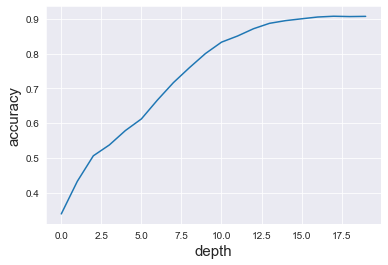

In [237]:
plt.plot(scores)
plt.ylabel('accuracy', fontsize=15)
plt.xlabel('depth', fontsize=15)

As expected the deeper the decision tree is, the more accurate it will be. But on the other hand, it might be more prone to overfit the data as we will see with the random forest.  

In [238]:
# best depth
np.argmax(scores)

17

### Features' importance

In [239]:
# feature importances for best classifier
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4)
clf.fit(X_train, y_train)
clf.feature_importances_
sorted(zip(X_train.columns, clf.feature_importances_), key=lambda x: x[1], reverse=True)

[('Port Code', 0.3749024727355527),
 ('Personal Vehicle Passengers', 0.33102827176972716),
 ('Mexico Border', 0.1673436317537384),
 ('Pedestrians', 0.0610157283675087),
 ('Bus Passengers', 0.032515370918425074),
 ('Train Passengers', 0.02517893409591569),
 (6, 0.00801559035913217),
 ('Year', 0.0),
 ('Month', 0.0),
 ('Canada Border', 0.0),
 (0, 0.0),
 (1, 0.0),
 (2, 0.0),
 (3, 0.0),
 (4, 0.0),
 (5, 0.0),
 (7, 0.0),
 (8, 0.0),
 (9, 0.0),
 (10, 0.0),
 (11, 0.0),
 (12, 0.0),
 (13, 0.0)]

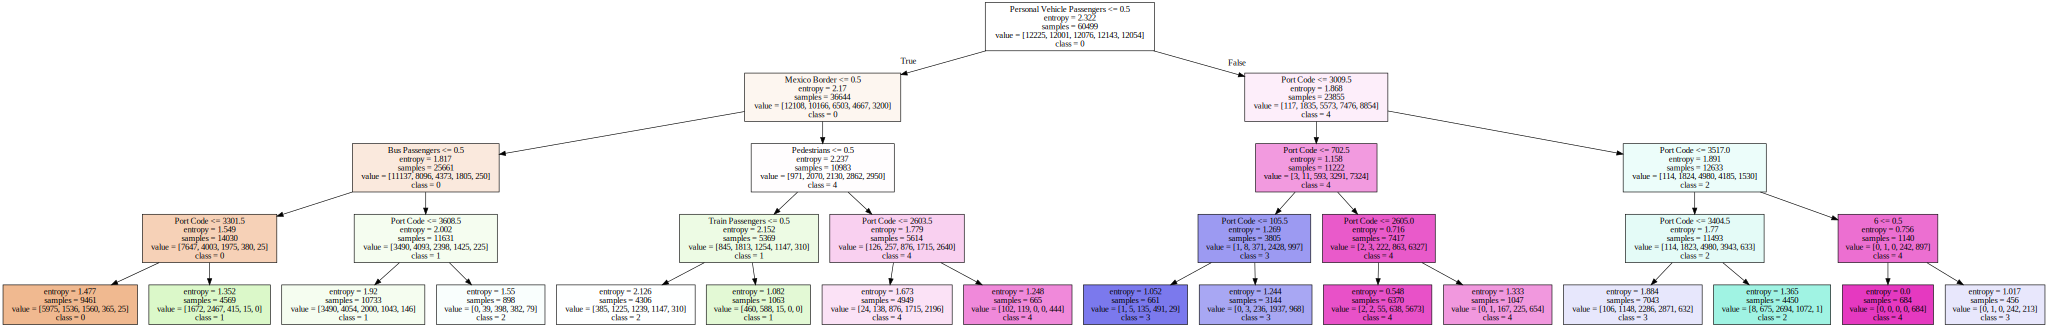

In [240]:
# visualizing the decision tree
graph = Source(export_graphviz(clf, out_file=None
   , feature_names=X_train.columns, class_names=['0','1','2','3','4','5','6','7'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))

No handles with labels found to put in legend.


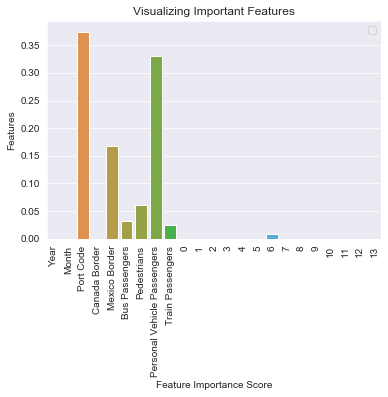

In [241]:
# Creating a bar plot
sns.barplot(x=X_train.columns, y=clf.feature_importances_)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.xticks(rotation=90)
plt.show()

# Random forest classifier

As we said decision tree are prone to overfit so we will use a similar but different model called the random forest. Their ability to limit overfitting without impacting to much the error is why they are such important models. They limit the effects of a bias.

In [242]:
rfc = RandomForestClassifier(n_jobs=2, random_state=0)

In [243]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [244]:
rfc.score(X_test,y_test)

0.893090909090909

We can see that the score is a little worse than for a decision tree, proof that in the decison tree model there was some overfitting.

In [245]:
sorted(zip(X_train.columns, rfc.feature_importances_), key=lambda x: x[1], reverse=True)

[('Port Code', 0.4399086101334686),
 ('Year', 0.14689729134397372),
 ('Month', 0.0974111720451845),
 ('Personal Vehicle Passengers', 0.08868019275716067),
 ('Bus Passengers', 0.03220873041092499),
 ('Pedestrians', 0.03107844596246976),
 ('Train Passengers', 0.027008881788209434),
 ('Canada Border', 0.02287208022318652),
 ('Mexico Border', 0.022311236246783293),
 (10, 0.011555015886963988),
 (9, 0.010335073353366314),
 (11, 0.010193806445955139),
 (5, 0.008741889161948133),
 (4, 0.0078028749799887),
 (3, 0.007199171326554736),
 (6, 0.005840272590361634),
 (13, 0.005730938030543984),
 (7, 0.005137837003052604),
 (2, 0.0051334259642887),
 (12, 0.0049785204194128865),
 (0, 0.0034354232291621467),
 (8, 0.0028717880268458408),
 (1, 0.002667322670193698)]

No handles with labels found to put in legend.


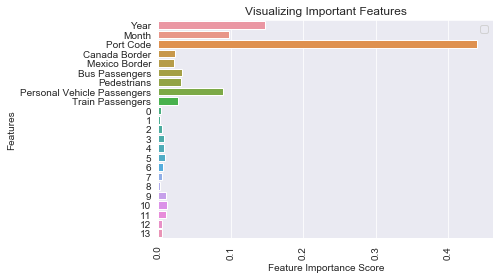

In [246]:
sns.barplot(x=rfc.feature_importances_,y=X_train.columns)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.xticks(rotation=90)
plt.show()

Like we had in the decision tree, 'Port Code' is the most important feature. But the second one, is different since this model gives way more importance to the temporality in the dataset. The decison tree might have overfitted on the 'Personal Vehicle Passengers' feature since it is the most represented one in a lot of ports. Here the random forest mitigates this effect.

# Results overview

In [5]:
results = [["Logistic Regression",0.54],["Linear Regression",0.62],["Decision Tree",0.84],["Random Forest",0.81]]
results = pd.DataFrame(results)
results = results.rename(columns={0:"model",1: "test_error"})
results

,model,test_error
0,Logistic Regression,0.54
1,Linear Regression,0.62
2,Decision Tree,0.84
3,Random Forest,0.81


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

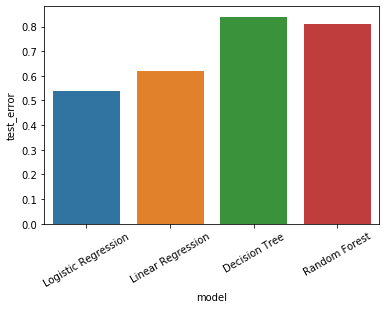

In [6]:
sns.barplot(x="model", y="test_error", data=results)
plt.xticks(rotation=30)